In [1]:
import numpy as np
import pandas as pd
import pydicom
from matplotlib import pyplot as plt
import os
from mask_functions import rle2mask
from google.cloud import storage

In [2]:
client = storage.Client()
print("Client created using default project: {}".format(client.project))

Client created using default project: golden-operator-241905


In [3]:
buckets = client.list_buckets()

print("Buckets in {}:".format(client.project))
for item in buckets:
    print("\t" + item.name)

Buckets in golden-operator-241905:
	pneumothorax_chest_x-rays


In [4]:
bucket = client.get_bucket("pneumothorax_chest_x-rays")

In [5]:
blobs = list(bucket.list_blobs(prefix='train/'))

In [ ]:
df = pd.read_csv('gs://pneumothorax_chest_x-rays/train-rle.csv')
df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...


In [ ]:
class DcmDataset(object):
    def __init__(self, blobs):
        self.blobs = blobs
    
    def __getitem__(self, idx):
        
        # load
        file_path = self.blobs[idx].name 
        img_id = file_path.split('/')[-1][:-4]     

        with open('./temp/temp.dcm', 'wb') as file_obj:
            self.blobs[idx].download_to_file(file_obj)
        
        # text
        dcm_data = pydicom.dcmread('./temp/temp.dcm')   
#         os.remove('./temp/temp.dcm')
        
        print(file_path)
        print(img_id)  
        print(dcm_data)
                
        # image
        img = dcm_data.pixel_array
        print(type(img))
        print(img.dtype)
        print(img.shape)
        plt.figure(figsize=(10,10))
        plt.imshow(img, cmap=plt.cm.bone)

        # mask
        df_temp = df.loc[df.ImageId == img_id]          
        rle = df_temp.iloc[0, 1].strip() # rle is the string in EncodedPixels column
        if rle == '-1':
            plt.ylabel('NO-MASK')
        
        else:
            mask = rle2mask(rle, 1024, 1024).T
            mask = np.uint8(mask)
            plt.ylabel('MASKED')
            plt.imshow(mask, alpha=0.3, cmap="Reds")
        

    def __len__(self):
        return len(self.blobs)

In [ ]:
dcms = DcmDataset(blobs)
len(dcms)

10675

train/1.2.276.0.7230010.3.1.2.8323329.4159.1517875181.421583/1.2.276.0.7230010.3.1.3.8323329.4159.1517875181.421582/1.2.276.0.7230010.3.1.4.8323329.4159.1517875181.421584.dcm
1.2.276.0.7230010.3.1.4.8323329.4159.1517875181.421584
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.4159.1517875181.421584
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '87719e02-8d90-4d05-b61c-f8e6315af9f

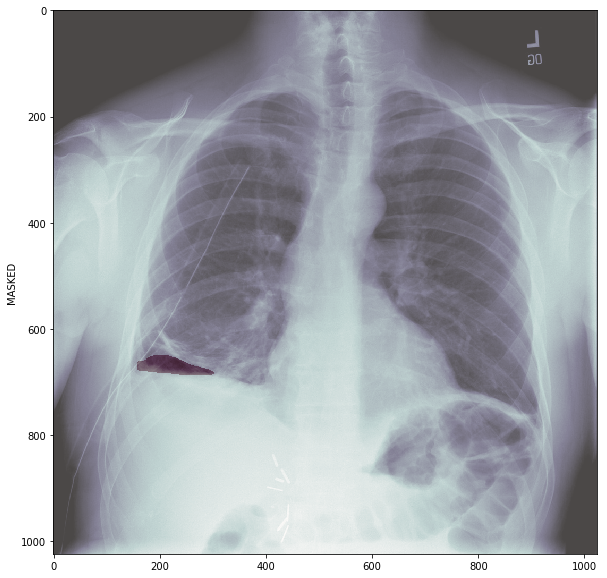

In [ ]:
dcms[8888]

In [ ]:
import torch
import torch.utils.data
import collections
from tqdm import tqdm_notebook
from PIL import Image

class TorchDataset(torch.utils.data.Dataset):
    def __init__(self, blobs, df, transforms=None):
        self.blobs = blobs
        self.transforms = transforms
        self.df = df
        
        self.image_info = collections.defaultdict(dict)
###        
        i = 0
        for blob in tqdm_notebook(self.blobs):
            file_path = blob.name
            img_id = file_path.split('/')[-1][:-4]
            
            df_temp = self.df.loc[self.df.ImageId == img_id]
            rle_list = list()
            for x in range(len(df_temp)):
                rle = df_temp.iloc[x, 1].strip()
                rle_list.append(rle)
            
            for y in rle_list:
                if y != '-1':
                    dcm_path = './dataset/{}.dcm'.format(img_id)
                    png_path = './dataset_png/{}.png'.format(img_id)

                    # if the dcm is not downloaded, download it.
                    if not os.path.exists(dcm_path):
                        with open(dcm_path, 'wb') as file_obj:
                            blob.download_to_file(file_obj)  
                    # if the png is not created, create it.
                    if not os.path.exists(png_path):
                        with open(png_path, 'wb') as file_obj:
                            dcm_data = pydicom.dcmread(dcm_path)#, force=True)
                            img = dcm_data.pixel_array
                            img_mem = Image.fromarray(img)
                            img_mem.save(file_obj)

                    self.image_info[i]["image_id"] = img_id
                    self.image_info[i]["image_path"] = png_path
                    self.image_info[i]["annotations"] = rle_list
                    i += 1
                    break

        print(i)
###           
            
    def __getitem__(self, idx):
        # images
        img_path = self.image_info[idx]["image_path"]
        img = Image.open(img_path).convert("RGB")

        # masks
        rle_list = self.image_info[idx]["annotations"] 
        mask = np.zeros((1024 ,1024))
        for i, rle in enumerate(rle_list):
            mask += rle2mask(rle_list[i], 1024, 1024).T
        mask = (mask > 127).astype(np.uint8)
        
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target
    

    def __len__(self):
        return len(self.image_info)

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
# use our dataset and defined transformations
dataset = TorchDataset(blobs, df, get_transform(train=True))
dataset_test = TorchDataset(blobs, df, get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])



2379



2379


In [ ]:
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
print(device)

cuda


In [ ]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [   0/1165]  eta: 0:48:08  lr: 0.000010  loss: 5.1355 (5.1355)  loss_classifier: 0.4849 (0.4849)  loss_box_reg: 0.0675 (0.0675)  loss_mask: 4.3707 (4.3707)  loss_objectness: 0.1996 (0.1996)  loss_rpn_box_reg: 0.0128 (0.0128)  time: 2.4793  data: 0.4828  max mem: 2246
Epoch: [0]  [  10/1165]  eta: 0:24:46  lr: 0.000060  loss: 3.3267 (3.2962)  loss_classifier: 0.4899 (0.4846)  loss_box_reg: 0.0530 (0.0502)  loss_mask: 2.6372 (2.6705)  loss_objectness: 0.0896 (0.0810)  loss_rpn_box_reg: 0.0093 (0.0098)  time: 1.2873  data: 0.0545  max mem: 2892
Epoch: [0]  [  20/1165]  eta: 0:23:26  lr: 0.000110  loss: 1.4878 (2.2299)  loss_classifier: 0.3679 (0.3755)  loss_box_reg: 0.0397 (0.0457)  loss_mask: 0.9080 (1.7153)  loss_objectness: 0.0627 (0.0840)  loss_rpn_box_reg: 0.0092 (0.0094)  time: 1.1661  data: 0.0110  max mem: 2892
Epoch: [0]  [  30/1165]  eta: 0:22:54  lr: 0.000160  loss: 0.9888 (1.8327)  loss_classifier: 0.1605 (0.2945)  loss_box_reg: 0.0442 (0.0494)  loss_mask: 0.6468 (

In [ ]:
with open('./model/model_para_0816.pt', 'wb') as f:
    torch.save(model.state_dict(), f)